In [110]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('B://workspace/tensorflow/')

# 训练 Conv-LSTM 模型。
# 该模型通过同一个月的前 14 天的 SST 数据预测未来 1 天的 SST 数据。

# 导入数据集
from torch.utils.data import DataLoader

# 定义参数
OFFSET = 29200
WIDTH = 15
STEP = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
from numpy import array
from torch.utils.data import random_split

from src.dataset.ERA5 import ERA5SSTDataset
from src.plot.sst import plot_sst_l, plot_sst_comparison

def get_lon(lon):
    lon_s = 360 + lon[0] if lon[0] <= 0 else lon[0]
    lon_e = 360 + lon[1] if lon[1] <= 0 else lon[1]
    
    print(lon_s, lon_e)
    
    return [lon_s, lon_e]

def split_data(area):
    lon = array(get_lon(area['lon']))
    lat = array(area['lat']) + 90

    dataset = ERA5SSTDataset(WIDTH, STEP, OFFSET, lon, lat)
    
    train_data_set, val_data_set, test_data_set = random_split(dataset, [0.7, 0.2, 0.1])

    train_dataloader = DataLoader(train_data_set, batch_size=20, shuffle=False)
    val_dataloader = DataLoader(val_data_set, batch_size=20, shuffle=False)
    test_dataloader = DataLoader(test_data_set, batch_size=20, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

def get_sst(): 
    lon = array([-180, 180]) + 180
    lat = array([-90, 90]) + 90

    dataset = ERA5SSTDataset(WIDTH, STEP, OFFSET, lon, lat)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    print(dataset.getTime(dataset.current))

    fore_, last_ = next(iter(loader))
    print(fore_.shape)

    return last_[0, :, :]

('2019-12-12', '2019-12-27')
torch.Size([1, 14, 1, 180, 360])
(360, 180)


<GeoAxes: >

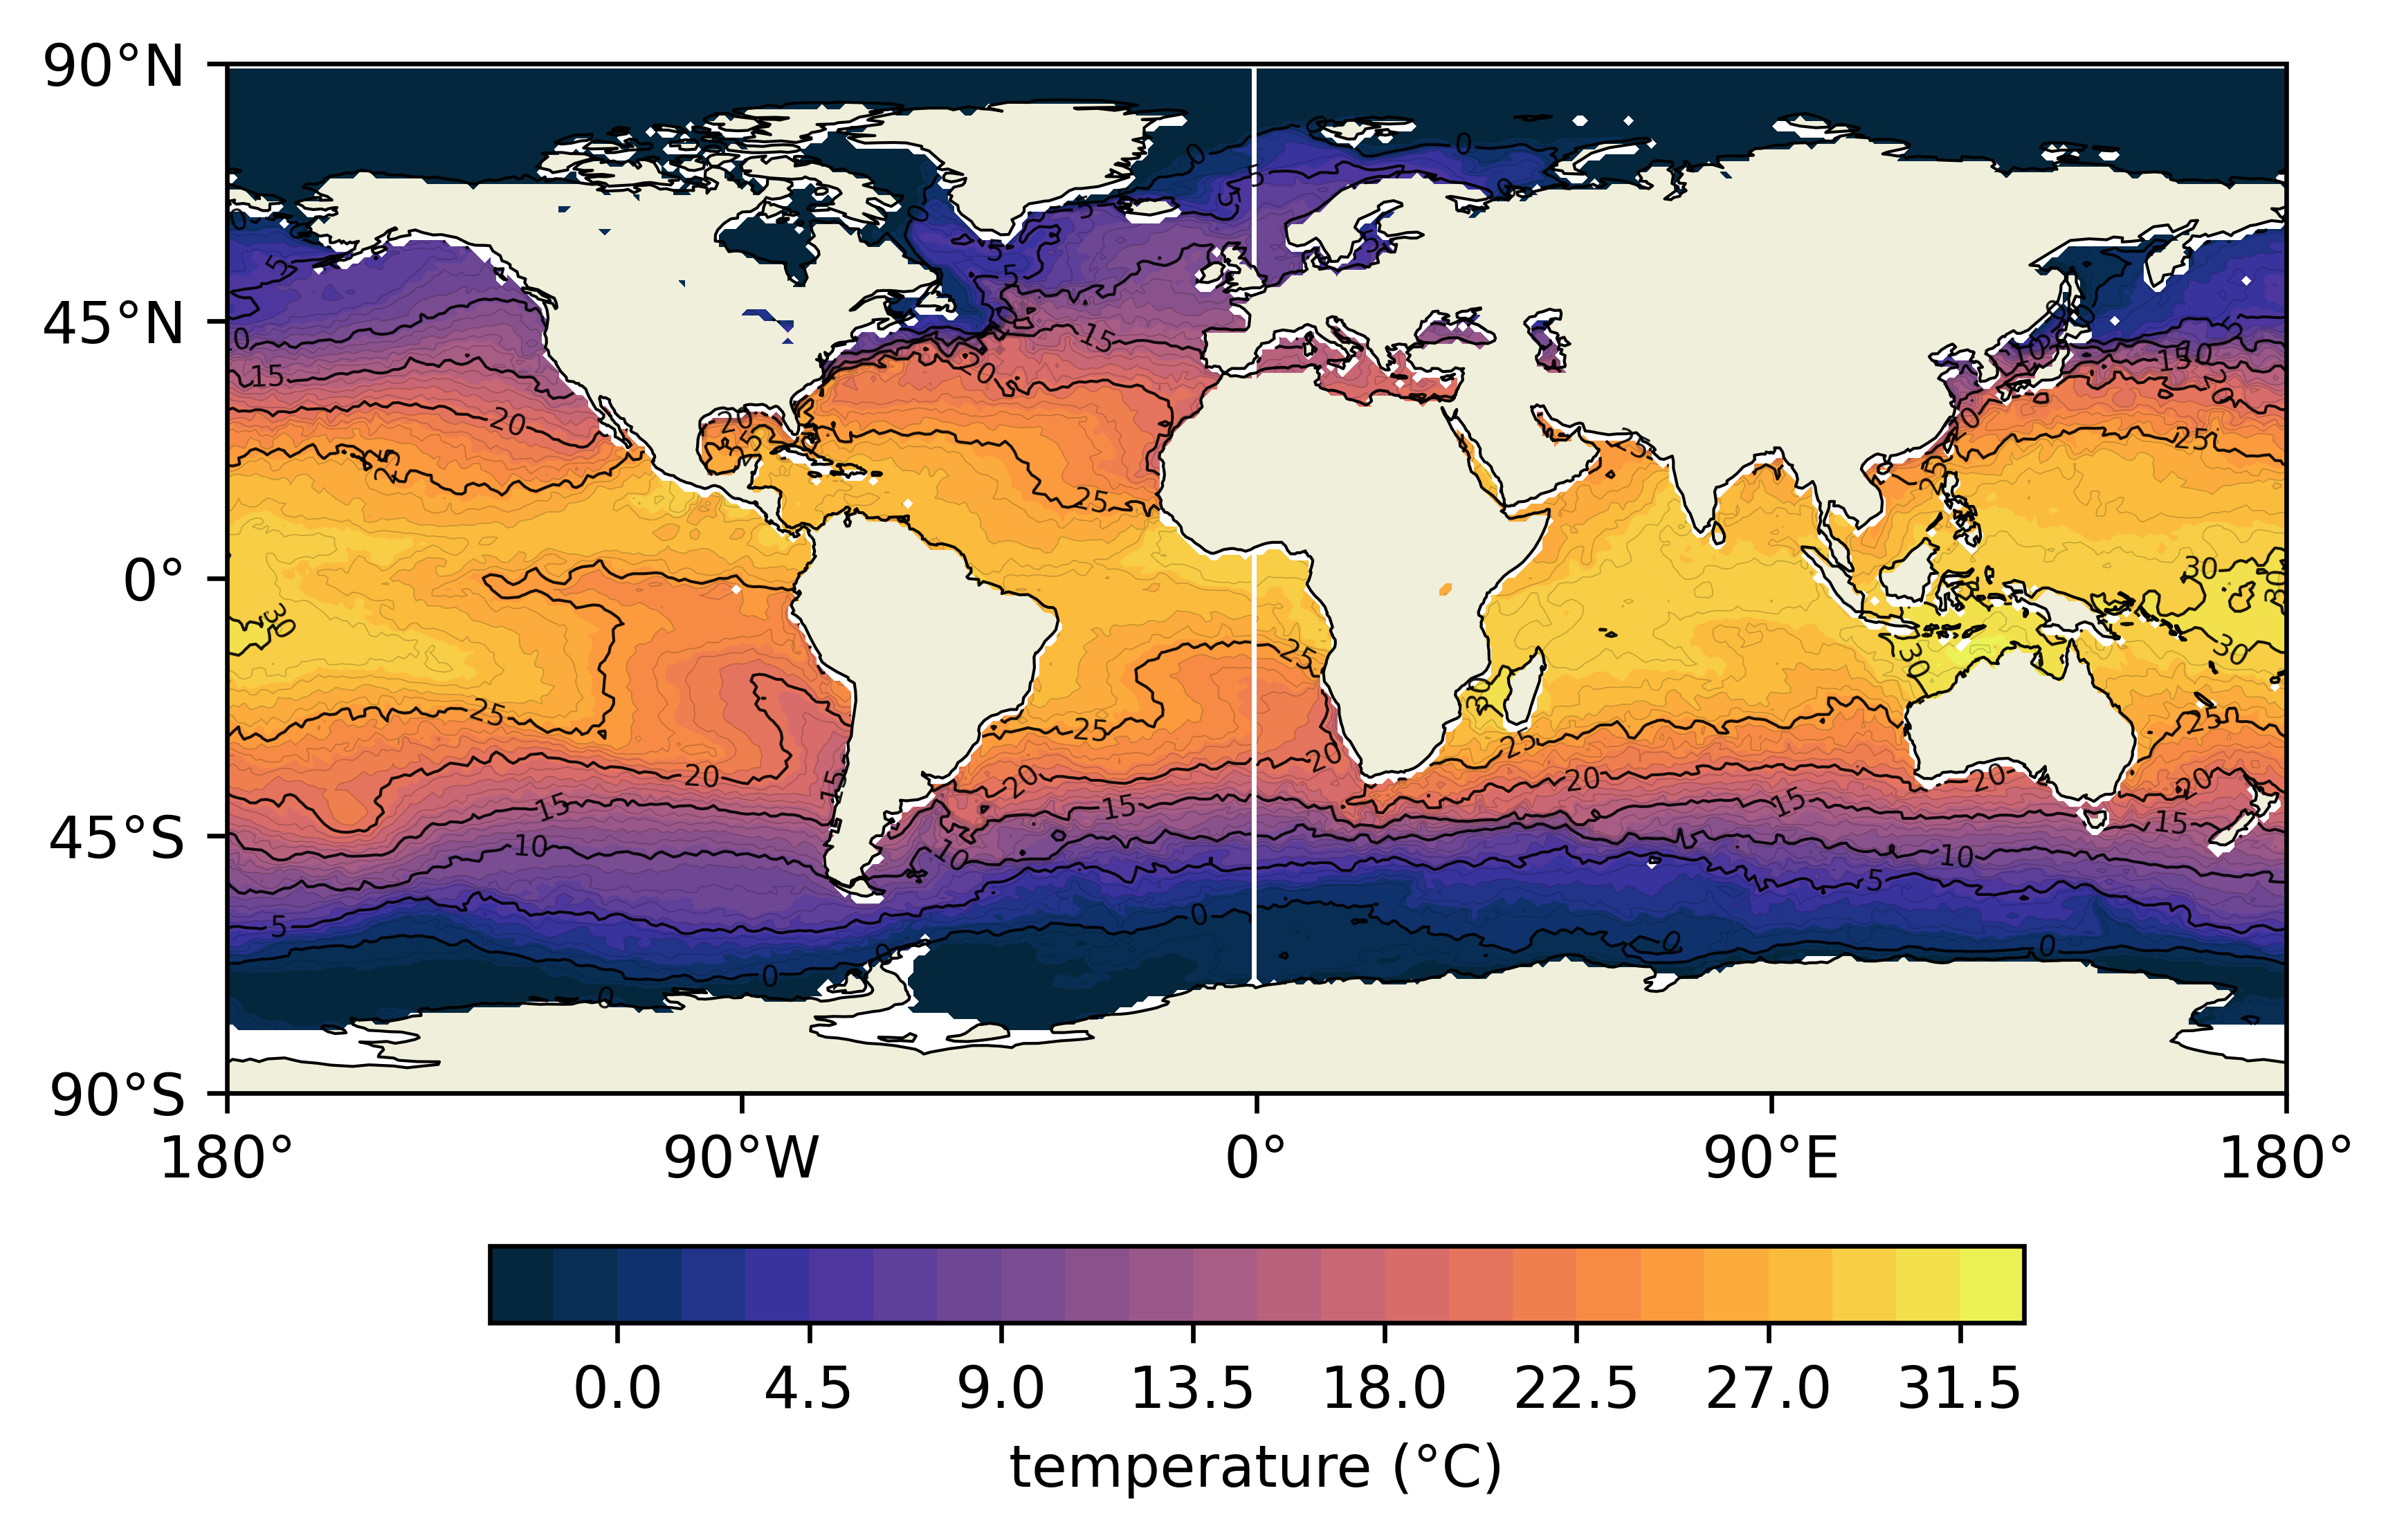

In [112]:
import numpy as np

sst = get_sst()[0, :, :].detach().numpy()
sst = np.transpose(sst, (1, 0))

print(sst.shape)

plot_sst_l(sst, lat=[-90, 90],lon=[-180, 180])

In [114]:
from lightning import Trainer # type: ignore
from lightning.pytorch.callbacks.early_stopping import EarlyStopping # type: ignore

from src.models.LSTM import ConvLSTM
from src.config.params import Areas

models = []
test_ = []

for area in Areas: 
    model = ConvLSTM(1, 10, kernel_size=(5,5), num_layers=5)
    el_stop = EarlyStopping(monitor='loss', patience=20, min_delta=0.05)
    
    train_dataloader, val_dataloader, test_dataloader = split_data(area)
    trainer = Trainer(max_epochs=30, limit_train_batches=200, enable_checkpointing=False, callbacks=[el_stop])

    trainer.fit(model, train_dataloaders=train_dataloader)
    
    models.append(model)
    test_.append(test_dataloader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | cell_list | ModuleList  | 91.2 K | train
1 | fc        | Sequential  | 1.6 M  | train
2 | nor       | BatchNorm2d | 20     | train
--------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.766     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


200 220
Epoch 0:   0%|          | 0/62 [00:00<?, ?it/s] 0
torch.Size([20, 14, 1, 20, 20])
 --- loss: 477.6973876953125
Epoch 0:   2%|▏         | 1/62 [00:00<00:58,  1.04it/s, v_num=88]1
torch.Size([20, 14, 1, 20, 20])
 --- loss: 474.412841796875
Epoch 0:   3%|▎         | 2/62 [00:01<00:51,  1.17it/s, v_num=88]2
torch.Size([20, 14, 1, 20, 20])
 --- loss: 473.2149658203125
Epoch 0:   5%|▍         | 3/62 [00:02<00:48,  1.22it/s, v_num=88]3
torch.Size([20, 14, 1, 20, 20])
 --- loss: 462.0379943847656
Epoch 0:   6%|▋         | 4/62 [00:03<00:46,  1.25it/s, v_num=88]4
torch.Size([20, 14, 1, 20, 20])
 --- loss: 445.9867858886719
Epoch 0:   8%|▊         | 5/62 [00:03<00:45,  1.25it/s, v_num=88]5
torch.Size([20, 14, 1, 20, 20])
 --- loss: 433.3238830566406
Epoch 0:  10%|▉         | 6/62 [00:04<00:45,  1.22it/s, v_num=88]6
torch.Size([20, 14, 1, 20, 20])
 --- loss: 411.0309143066406
Epoch 0:  11%|█▏        | 7/62 [00:05<00:44,  1.24it/s, v_num=88]7
torch.Size([20, 14, 1, 20, 20])
 --- loss: 432.

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s, v_num=88]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



220 240


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | cell_list | ModuleList  | 91.2 K | train
1 | fc        | Sequential  | 1.6 M  | train
2 | nor       | BatchNorm2d | 20     | train
--------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.766     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/62 [00:00<?, ?it/s] 0
torch.Size([20, 14, 1, 20, 20])
 --- loss: 453.642578125
Epoch 0:   2%|▏         | 1/62 [00:00<00:48,  1.26it/s, v_num=91]1
torch.Size([20, 14, 1, 20, 20])
 --- loss: 441.1851806640625
Epoch 0:   3%|▎         | 2/62 [00:01<00:46,  1.30it/s, v_num=91]2
torch.Size([20, 14, 1, 20, 20])
 --- loss: 428.8902282714844
Epoch 0:   5%|▍         | 3/62 [00:02<00:45,  1.30it/s, v_num=91]3
torch.Size([20, 14, 1, 20, 20])
 --- loss: 431.155517578125
Epoch 0:   6%|▋         | 4/62 [00:03<00:46,  1.24it/s, v_num=91]4
torch.Size([20, 14, 1, 20, 20])
 --- loss: 435.0751953125
Epoch 0:   8%|▊         | 5/62 [00:03<00:45,  1.26it/s, v_num=91]5
torch.Size([20, 14, 1, 20, 20])
 --- loss: 424.6440734863281
Epoch 0:  10%|▉         | 6/62 [00:04<00:43,  1.28it/s, v_num=91]6
torch.Size([20, 14, 1, 20, 20])
 --- loss: 412.00762939453125
Epoch 0:  11%|█▏        | 7/62 [00:05<00:42,  1.29it/s, v_num=91]7
torch.Size([20, 14, 1, 20, 20])
 --- loss: 394.2224426269531


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | cell_list | ModuleList  | 91.2 K | train
1 | fc        | Sequential  | 1.6 M  | train
2 | nor       | BatchNorm2d | 20     | train
--------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.766     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/62 [00:00<?, ?it/s] 0
torch.Size([20, 14, 1, 20, 20])
 --- loss: 783.9647827148438
Epoch 0:   2%|▏         | 1/62 [00:00<00:58,  1.04it/s, v_num=97]1
torch.Size([20, 14, 1, 20, 20])
 --- loss: 787.17041015625
Epoch 0:   3%|▎         | 2/62 [00:01<00:55,  1.08it/s, v_num=97]2
torch.Size([20, 14, 1, 20, 20])
 --- loss: 767.5520629882812
Epoch 0:   5%|▍         | 3/62 [00:02<00:55,  1.07it/s, v_num=97]3
torch.Size([20, 14, 1, 20, 20])
 --- loss: 757.4760131835938
Epoch 0:   6%|▋         | 4/62 [00:03<00:53,  1.08it/s, v_num=97]4
torch.Size([20, 14, 1, 20, 20])
 --- loss: 742.7095947265625
Epoch 0:   8%|▊         | 5/62 [00:04<00:52,  1.09it/s, v_num=97]5
torch.Size([20, 14, 1, 20, 20])
 --- loss: 725.8290405273438
Epoch 0:  10%|▉         | 6/62 [00:05<00:51,  1.08it/s, v_num=97]6
torch.Size([20, 14, 1, 20, 20])
 --- loss: 717.6456298828125
Epoch 0:  11%|█▏        | 7/62 [00:06<00:51,  1.06it/s, v_num=97]7
torch.Size([20, 14, 1, 20, 20])
 --- loss: 724.957397460

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s, v_num=97]
320 340


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | cell_list | ModuleList  | 91.2 K | train
1 | fc        | Sequential  | 1.6 M  | train
2 | nor       | BatchNorm2d | 20     | train
--------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.766     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/62 [00:00<?, ?it/s] 0
torch.Size([20, 14, 1, 20, 20])
 --- loss: 473.8216857910156
Epoch 0:   2%|▏         | 1/62 [00:00<00:57,  1.06it/s, v_num=100]1
torch.Size([20, 14, 1, 20, 20])
 --- loss: 472.4980773925781
Epoch 0:   3%|▎         | 2/62 [00:01<00:54,  1.10it/s, v_num=100]2
torch.Size([20, 14, 1, 20, 20])
 --- loss: 466.29888916015625
Epoch 0:   5%|▍         | 3/62 [00:02<00:53,  1.10it/s, v_num=100]3
torch.Size([20, 14, 1, 20, 20])
 --- loss: 458.8145751953125
Epoch 0:   6%|▋         | 4/62 [00:03<00:51,  1.12it/s, v_num=100]4
torch.Size([20, 14, 1, 20, 20])
 --- loss: 433.5408020019531
Epoch 0:   8%|▊         | 5/62 [00:04<00:50,  1.13it/s, v_num=100]5
torch.Size([20, 14, 1, 20, 20])
 --- loss: 431.90667724609375
Epoch 0:  10%|▉         | 6/62 [00:05<00:49,  1.12it/s, v_num=100]6
torch.Size([20, 14, 1, 20, 20])
 --- loss: 413.67047119140625
Epoch 0:  11%|█▏        | 7/62 [00:06<00:49,  1.11it/s, v_num=100]7
torch.Size([20, 14, 1, 20, 20])
 --- loss: 4

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 62/62 [00:58<00:00,  1.05it/s, v_num=100]


200 220
torch.Size([20, 14, 1, 20, 20])
RMSE: 8.631063461303711
220 240
torch.Size([20, 14, 1, 20, 20])
RMSE: 30.746753692626953
70 90
torch.Size([20, 14, 1, 20, 20])
RMSE: 38.295005798339844
320 340
torch.Size([20, 14, 1, 20, 20])
RMSE: 6.660240173339844


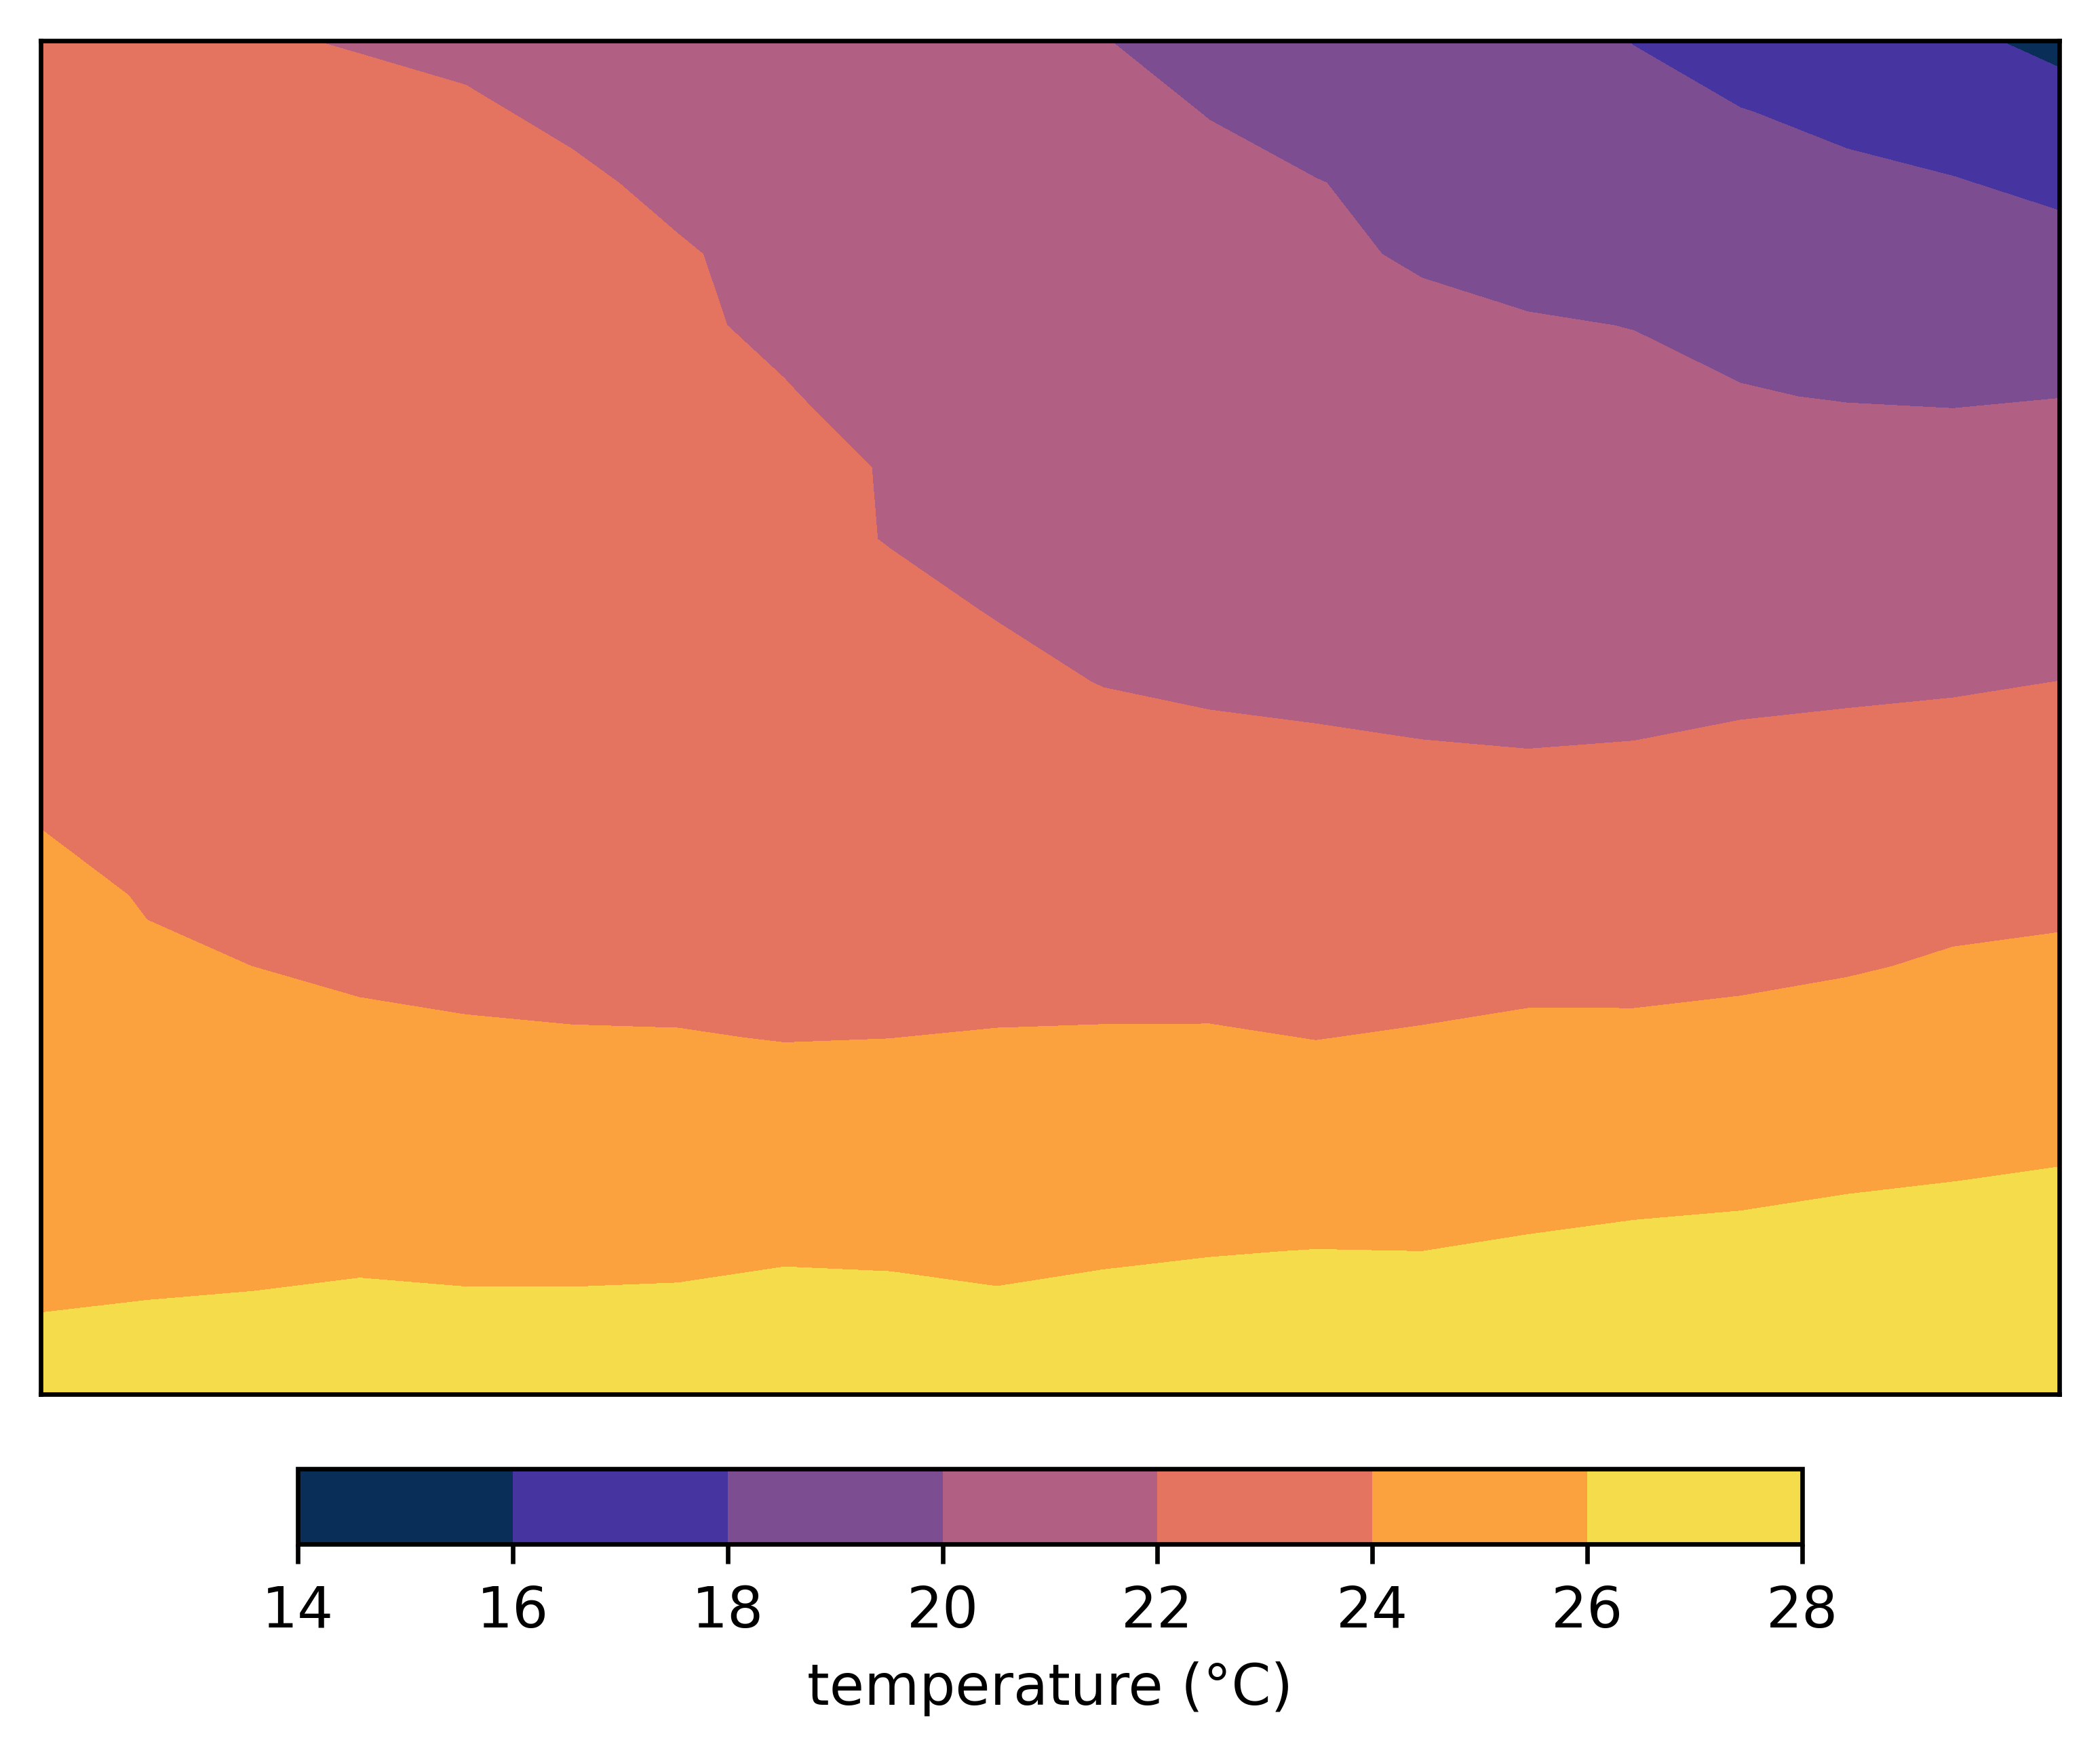

In [138]:
from sklearn.metrics import mean_squared_error
from src.plot.sst import plot_sst


for index in range(len(Areas)):
    area = Areas[index]
    model = models[index]
    lon = array(get_lon(area['lon']))
    lat = array(area['lat']) + 90
    
    test_dataloader = test_[index]
    x_test, y_test = next(iter(test_dataloader))
    
    y_pred = model(x_test)
    
    g = y_pred[1, 0, :, :]
    # y = y_test[1, 0, :, :]
    
    rmse = mean_squared_error(y.detach().numpy(), g.detach().numpy())
    print(f"RMSE: {rmse}")
    # plot_sst_comparison(y.detach().numpy(), g.detach().numpy(), lon, lat)
    plot_sst(g.detach().numpy(), lon, lat)
    


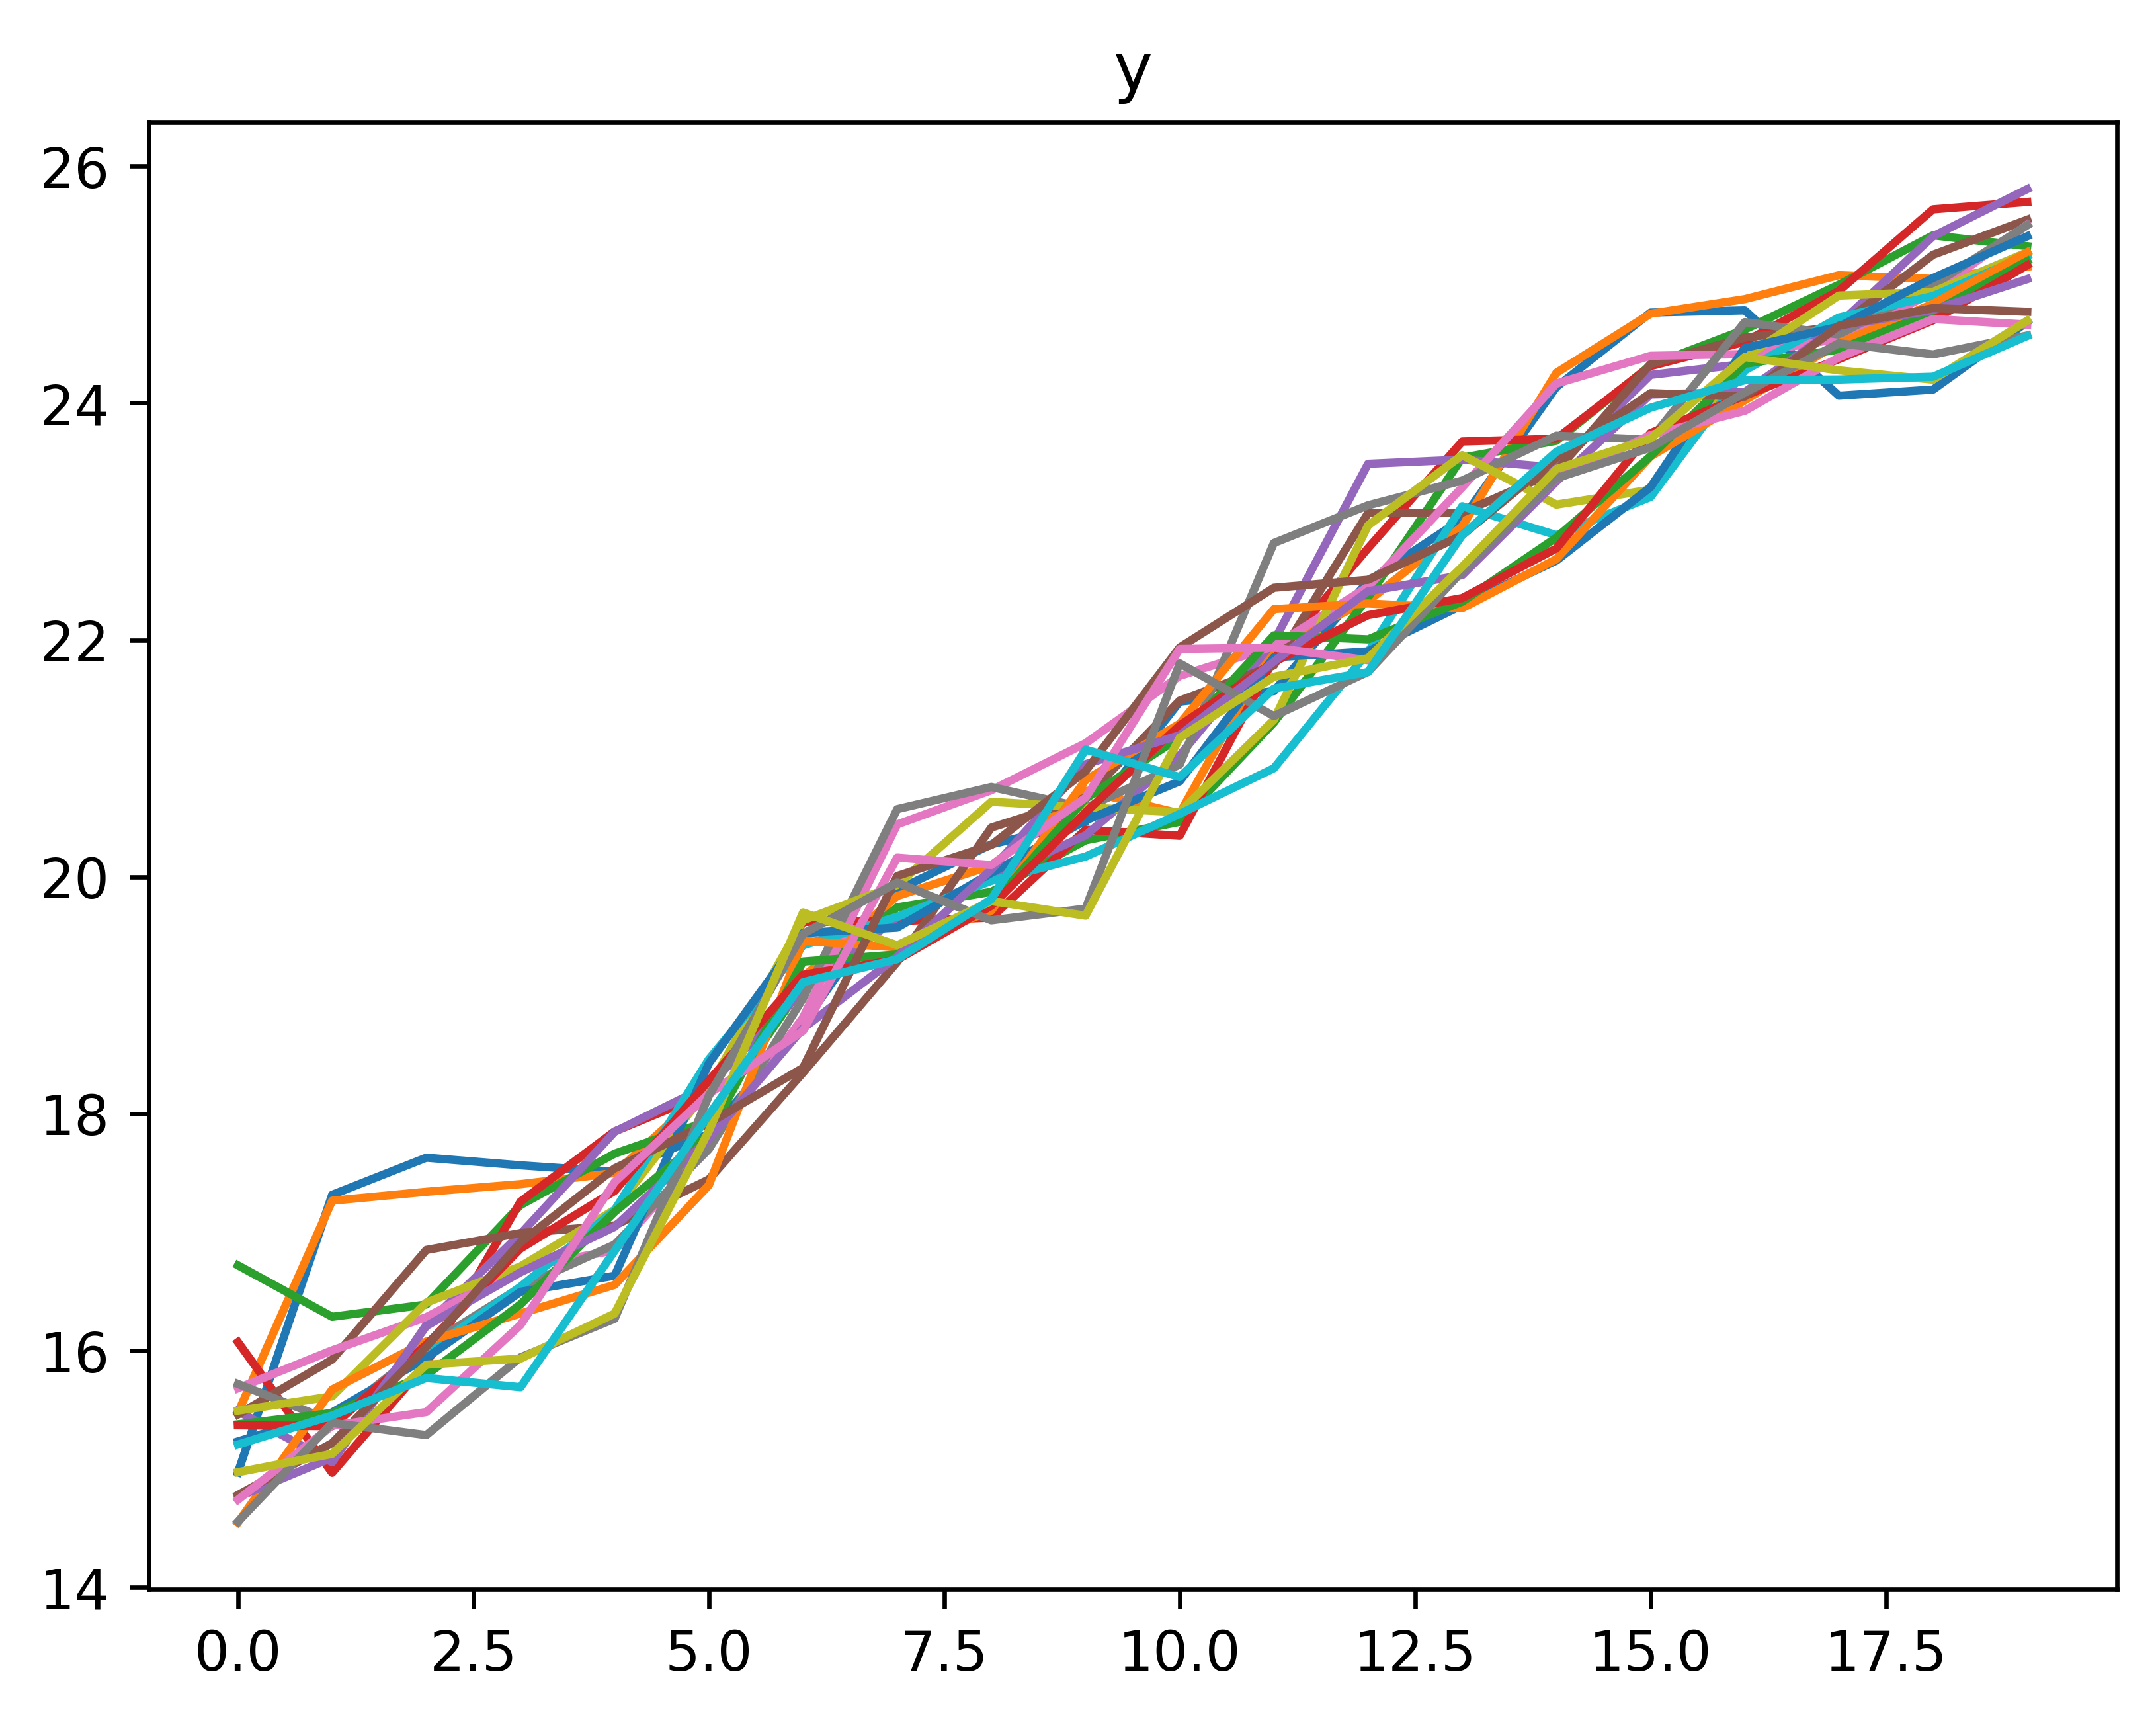

In [134]:
from src.plot.base import create_ax

ax1 = create_ax()
ax2 = create_ax()

for i in range(g.shape[0]):
    ax1.plot(g.detach().numpy()[:, i])
    ax1.title.set_text('g')
    ax2.plot(y.detach().numpy()[:, i])
    ax2.title.set_text('y')